# Image processing 1: Edge detection using approximated adder

Author: Vladislav Válek

In [162]:
# Loading required packages packages
from skimage import io, img_as_float, img_as_ubyte
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from itertools import permutations
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from multiprocessing import Pool, cpu_count



## Adders

### Exact Adder Function

Outpus also the energy consumption for each result.

In [163]:
def exactAdder(a, b, c):
    if a==0 and b==0 and c==0:
        s=0
        c_out=0
        energy_consumption = 4971
    elif a==0 and b==0 and c==1:
        s=1
        c_out=0
        energy_consumption = 123 
    elif a==0 and b==1 and c==0:
        s=1
        c_out=0
        energy_consumption = 3021 
    elif a==0 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 8293 
    elif a==1 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 2175 
    elif a==1 and b==0 and c==1:
        s=0
        c_out=1
        energy_consumption = 2397 
    elif a==1 and b==1 and c==0:
        s=0
        c_out=1
        energy_consumption = 1092 
    elif a==1 and b==1 and c==1:
        s=1
        c_out=1
        energy_consumption = 13
    return s, c_out, energy_consumption

### Approximate Adder Function

The output result deviates from the exact solution.

Failure Cases:
- Input (0, 0, 0): Incorrect sum (s) = 1 Correct carry-out (c_out) = 0
- Input (1, 1, 1): Incorrect sum (s) = 0 Correct carry-out (c_out) = 1


In [164]:
def approxAdder(a, b, c):
    if a==0 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 984
    elif a==0 and b==0 and c==1:
        s=1
        c_out=0
        energy_consumption = 1098
    elif a==0 and b==1 and c==0:
        s=1
        c_out=0
        energy_consumption = 831 
    elif a==0 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 239 
    elif a==1 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 492 
    elif a==1 and b==0 and c==1:
        s=0
        c_out=1
        energy_consumption = 319 
    elif a==1 and b==1 and c==0:
        s=0
        c_out=1
        energy_consumption = 598 
    elif a==1 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 658 
    return s, c_out, energy_consumption

# def approxAdder(a, b, c):
#     if a==0 and b==0 and c==0:
#         s=1
#         c_out=0
#         energy_consumption = 984
#     elif a==0 and b==0 and c==1:
#         s=1
#         c_out=1
#         energy_consumption = 1098
#     elif a==0 and b==1 and c==0:
#         s=1
#         c_out=0
#         energy_consumption = 831 
#     elif a==0 and b==1 and c==1:
#         s=1
#         c_out=1
#         energy_consumption = 239 
#     elif a==1 and b==0 and c==0:
#         s=1
#         c_out=0
#         energy_consumption = 492 
#     elif a==1 and b==0 and c==1:
#         s=1
#         c_out=1
#         energy_consumption = 319 
#     elif a==1 and b==1 and c==0:
#         s=0
#         c_out=1
#         energy_consumption = 598 
#     elif a==1 and b==1 and c==1:
#         s=1
#         c_out=1
#         energy_consumption = 658 
#     return s, c_out, energy_consumption

### N-bit Adder Function

The MyNbitAdder function is designed to perform N-bit addition. Approximation takes place from lower bits to higher ones and the amount of approximated bits can be configured with 'approx_until' parameter. THe adder can also work with negative numbers as inputs. The 'n' parameter defines the bit length of the internally represented binary numbers. 

In [165]:
def multiBitAdder(a,b, nbits = 12, approx_until = 0):
    
    # Ensure that a and b are within range of signed integer
    a = (a + 2**(nbits - 1)) % 2**nbits - 2**(nbits - 1)
    b = (b + 2**(nbits - 1)) % 2**nbits - 2**(nbits - 1)

    #convert to binary and cut off the first two indices (they dont belong to the number but indicate that it is binary)
    # Eventually fill with 0 to the full length of n
    a_bin = bin(a & ((1 << nbits) - 1))[2:].zfill(nbits)
    b_bin = bin(b & ((1 << nbits) - 1))[2:].zfill(nbits)

    #reverse order bits for the adder
    rev_a , rev_b = list(a_bin[::-1]), list(b_bin[::-1])
    
    carry_over   = 0
    total_sum    = 0
    total_energy = 0
    
    #we want to do a bitwise addition
    for index, (bit1, bit2) in enumerate( zip(rev_a, rev_b) ):

        if index < approx_until:
            #use approx_adder
            sum_element, carry_over, energy = approxAdder(int(bit1), int(bit2), int(carry_over) ) 
        else:
            #use exact_adder
            sum_element, carry_over, energy = exactAdder(int(bit1), int(bit2), int(carry_over) )
            
        total_sum += pow(2,index)*sum_element
        total_energy += energy

    if total_sum >= 2**(nbits-1):
        total_sum -= 2**nbits 

    return total_sum, total_energy

test_cases = [
    (0, 0),     # 0 + 0 = 0
    (0, -1),     # 0 + -1 = -1
    (-1, 0),     # -1 + 0 = 0
    (5, 7),     # 5 + 7 = 12
    (-1, -1),   # -1 + -1 = -2 (overflow)
    (8, -3),    # 8 + (-3) = 5
    (-8, 3),    # -8 + 3 = -5
    (-8, -3),   # -8 + (-3) = -11
    (15, 1),    # 15 + 1 = -16 (overflow)
]

for a, b in test_cases:
    result,enrg = multiBitAdder(a, b)
    print(f"multiBitAdder({a}, {b}) = {result,enrg}, test: {result == a+b}")

multiBitAdder(0, 0) = (0, 59652), test: True
multiBitAdder(0, -1) = (-1, 36252), test: True
multiBitAdder(-1, 0) = (-1, 26100), test: True
multiBitAdder(5, 7) = (12, 49289), test: True
multiBitAdder(-1, -1) = (-2, 1235), test: True
multiBitAdder(8, -3) = (5, 78449), test: True
multiBitAdder(-8, 3) = (-5, 30588), test: True
multiBitAdder(-8, -3) = (-11, 12209), test: True
multiBitAdder(15, 1) = (16, 43203), test: True


## Filters for image processing

1) Low Pass Filter

    - f1: Low pass average filter

    These filters are designed for tasks such as removing noise from images or smoothing/blurring images. The key characteristic is that the sum of all the kernel elements should be one.

2) Filters for edge detection 

    - sobel_vertical   : Sobel vertical edge filter
    - sobel_horizontal : Sobel horizontal edge filter

    These filters are a form of high-pass filters. The sum of all elements within each of them should be 0.

In [166]:
f1 = [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]
f1 = 1/9 *np.array(f1)

sobel_vertical = [
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
]
sobel_vertical = np.array(sobel_vertical)

sobel_horizontal = [
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]
sobel_horizontal = np.array(sobel_horizontal)


## Derived adder function
These are designed for specific applications that use MyNbiAdder internally.

### Reduction sum
This function takes a 1D or 2D array of number and adds all its elements together. It uses MyNbitAdder for addition. This functionality as also known as folding.

In [167]:
def sumReduction(n, nbits = 12, approx_until = 0):

    # n = n.astype(int)
    shap = n.shape
    total_energy = 0

    if (len(shap) == 1):
        res = n[0]

        for i in range(1,shap[0]):
            res,energy = multiBitAdder(res,n[i], nbits = nbits, approx_until = approx_until)
            total_energy += energy

    elif (len(shap) == 2):
        res = n[0,0]

        for i in range(shap[0]):
            for j in range(shap[1]):

                # There is no reason to calculating this because we are reducing a matrix so 
                # first element is only saved and the algorithm goes on.
                if (i == 0 and j == 0): continue

                res,energy = multiBitAdder(res,n[i,j], nbits = nbits, approx_until = approx_until)
                total_energy += energy
    
    return res, total_energy

sumReduction(sobel_horizontal)

(0, 240501)

### Scalar functions 

It hurts, but it has to be done. These just accept single integer numbers.

In [168]:
def laMultiplication(a, b, nbits = 12, approx_until = 0):
    """This accepts two parameters and performs artificial multiplication
    by successive addition."""

    # An identity value for multiplication is normally 1 but since this 
    # multiplication is done by successive addition, the sum identity is taken 
    # instead.
    res = 0
    total_energy = 0
    # a = a.astype(int)
    # b = a.astype(int)

    if (a == 0 or b == 0):
        return 0, 0

    # Negative numbers have to be converted to the positive but the sign
    # has to remain for the result.
    neg_res_flag = True if ((a < 0 and b > 0) or (a > 0 and b < 0)) else False

    if a < 0:
        a, enrg = multiBitAdder(0,-a, nbits = nbits, approx_until = approx_until)
        total_energy += enrg

    if b < 0:
        b, enrg = multiBitAdder(0,-b, nbits = nbits, approx_until = approx_until)
        total_energy += enrg

    for _ in range(b):
        res, energy = multiBitAdder(res,a, nbits = nbits, approx_until = approx_until)
        total_energy += energy

    if neg_res_flag:
        res *= -1

    return res, total_energy

test_cases = [
    (0, 0),    
    (0, -1),   
    (-1, 0),   
    (5, 7),    
    (-1, -1),  
    (8, -3),   
    (8, -1),   
    (-8, 3),   
    (-8, -3),  
    (15, 1),   
    (3, 3),
    (40,0),
    (16,1024)
]

for a, b in test_cases:
    result,enrg = laMultiplication(a, b)
    print(f"laMultiplication({a}, {b}) = {result, enrg}, test: {result == a*b}")

def laSquare(a, nbits = 12, approx_until = 0):
    """Derivate of laMultiplication performing square operation"""

    return laMultiplication(a, a, nbits = nbits, approx_until=approx_until)

test_cases = [0, -1, -2, 2, 6, 64, -10, 5, 16, -8, 1]

for a in test_cases:
    result,enrg = laSquare(a, nbits=16)
    print(f"laSquare({a}) = {result,enrg}, test: {result == a**2}")


laMultiplication(0, 0) = (0, 0), test: True
laMultiplication(0, -1) = (0, 0), test: True
laMultiplication(-1, 0) = (0, 0), test: True
laMultiplication(5, 7) = (35, 319522), test: True
laMultiplication(-1, -1) = (1, 173106), test: True
laMultiplication(8, -3) = (-24, 219285), test: True
laMultiplication(8, -1) = (-8, 115404), test: True
laMultiplication(-8, 3) = (-24, 221235), test: True
laMultiplication(-8, -3) = (24, 276987), test: True
laMultiplication(15, 1) = (15, 51852), test: True
laMultiplication(3, 3) = (9, 148120), test: True
laMultiplication(40, 0) = (0, 0), test: True
laMultiplication(16, 1024) = (0, 45728328), test: False
laSquare(0) = (0, 0), test: True
laSquare(-1) = (1, 232758), test: True
laSquare(-2) = (4, 303567), test: True
laSquare(2) = (4, 148395), test: True
laSquare(6) = (36, 409854), test: True
laSquare(64) = (4096, 4308162), test: True
laSquare(-10) = (100, 805499), test: True
laSquare(5) = (25, 334528), test: True
laSquare(16) = (256, 1121610), test: True
laSq

In [212]:
def laSqRoot(a, nbits = 16, approx_until = 0):

    R = a    
    total_energy = 0

    R_sq,enrg = laSquare(R, nbits, approx_until)
    # print("R_sq:", R_sq)
    total_energy += enrg

    while (R_sq > a):
        R, enrg = multiBitAdder(R, -1, nbits, approx_until)
        # print("R:", R)
        total_energy += enrg
        R_sq,enrg = laSquare(R, nbits, approx_until)
        # print("R_sq:", R_sq)
        total_energy += enrg

    return R,total_energy


tst_cases = [(0,0), (1,1), (2,1), (4,2), (8,2), (16, 4), (25,5), (30,5), (784, 28), (807, 28)]
# tst_cases = [(784, 28)]

for tst, _ in tst_cases:
   res, enrg = laSqRoot(tst, nbits = 21) 
   corr_res = int(tst ** 0.5)
   print(f"laSqRoot({tst}) = {res,enrg}, correct: {res == corr_res} ({corr_res})")

laSqRoot(784) = (28, 21764517966), correct: True (28)


## Operator skeletons

In [170]:
def decideSeqPar(func, chunk_size, num_processes, inp_flat,  nbits = 12, approx_until = 0, use_parallel = False):
    if use_parallel:
        pool = Pool(processes=num_processes)  # Create a pool of processes
    
    chunk_indices = range(0, len(inp_flat[0]), chunk_size)
    if len(inp_flat) == 1:
        args = [(inp_flat[0][i:i+chunk_size], nbits, approx_until) for i in chunk_indices]
    elif len(inp_flat) == 2:
        args = [(inp_flat[0][i:i+chunk_size], inp_flat[1][i:i+chunk_size], nbits, approx_until) for i in chunk_indices]

    if use_parallel:
        results = pool.map(func, args)
    else:
        results =[[] for _ in range(len(args))]        
        for i, arg in enumerate(args, 0):
            results[i] = func(arg)

    if use_parallel:
        pool.close()
        pool.join()
    return results

def binaryVectOp(func, a, b, nbits = 12, approx_until = 0, use_parallel = False):
    
    a_shap = a.shape

    if (a_shap != b.shape):
        return -1,-1

    a_flat = a.flat
    b_flat = b.flat

    res_flat = np.zeros_like(a_flat)
    total_energy = 0
    num_processes = cpu_count()
    chunk_size = int(np.ceil(len(a_flat) / num_processes))

    results = decideSeqPar(func, chunk_size, num_processes, (a_flat, b_flat), nbits, approx_until, use_parallel)
    for i, chunk_result in enumerate(results):
        for j, (r, energy) in enumerate(chunk_result):
            idx = i * chunk_size + j
            if idx < len(res_flat):
                res_flat[idx] = r
                total_energy += energy

    # Reshape the flattened result back to the original shape
    res = np.reshape(res_flat, a.shape)

    return res, total_energy

def unaryVectOp(func, a, nbits = 12, approx_until = 0, use_parallel = False):
    
    a_shap = a.shape
    a_flat = a.flat

    res_flat = np.zeros_like(a_flat)
    total_energy = 0
    num_processes = cpu_count()
    chunk_size = int(np.ceil(len(a_flat) / num_processes))

    results = decideSeqPar(func, chunk_size, num_processes, (a_flat,), nbits, approx_until, use_parallel)
    for i, chunk_result in enumerate(results):
        for j, (r, energy) in enumerate(chunk_result):
            idx = i * chunk_size + j
            if idx < len(res_flat):
                res_flat[idx] = r
                total_energy += energy

    # Reshape the flattened result back to the original shape
    res = np.reshape(res_flat, a.shape)

    return res, total_energy

### Vector functions 

These can be applied either on matrices or vectors.

In [171]:
# Definition of test vectors and test permutations
test_matrices = np.array([
    [[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]],

    [[9, 8, 7],
    [6, 5, 4],
    [3, 2, 1]],

    [[2, 4, 6],
    [8, 10, 12],
    [14, 16, 18]],

    [[18, 16, 14],
    [12, 10, 8],
    [6, 4, 2]]
])

test_vectors = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [3, 6, 9],
    [9, 6, 3]
])


In [172]:
def add_chunk(args):
    a_chunk, b_chunk, nbits, approx_until = args
    return [multiBitAdder(a_elem, b_elem, nbits, approx_until) for a_elem, b_elem in zip(a_chunk, b_chunk)]

def laAddVect(a, b, nbits = 12, approx_until = 0, use_parallel = False):
    return binaryVectOp(add_chunk, a, b, nbits, approx_until, use_parallel)

test_matrix_permut = permutations(range(test_matrices.shape[0]), 2)
test_vector_permut = permutations(range(test_vectors.shape[0]), 2)

for i in test_matrix_permut:
    tst_matrix_a = test_matrices[i[0]]
    tst_matrix_b = test_matrices[i[1]]
    add_res, enrg = laAddVect(tst_matrix_a, tst_matrix_b)
    correct_res = tst_matrix_a + tst_matrix_b

    is_res_correct = np.array_equal(correct_res, add_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')

    print(f"laAddVect of {tst_matrix_a} and {tst_matrix_b} = {add_res,enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')

for i in test_vector_permut:
    tst_vector_a = test_vectors[i[0]]
    tst_vector_b = test_vectors[i[1]]
    add_res, enrg = laAddVect(tst_vector_a, tst_vector_b)
    correct_res = tst_vector_a + tst_vector_b

    is_res_correct = np.array_equal(correct_res, add_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')

    print(f"laAddVect of {tst_vector_a} and {tst_vector_b} = {add_res,enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')


laAddVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] and [[9 8 7]
 [6 5 4]
 [3 2 1]] = (array([[10, 10, 10],
       [10, 10, 10],
       [10, 10, 10]]), 438900), correct: True
laAddVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] and [[ 2  4  6]
 [ 8 10 12]
 [14 16 18]] = (array([[ 3,  6,  9],
       [12, 15, 18],
       [21, 24, 27]]), 469339), correct: True
laAddVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] and [[18 16 14]
 [12 10  8]
 [ 6  4  2]] = (array([[19, 18, 17],
       [16, 15, 14],
       [13, 12, 11]]), 469339), correct: True
laAddVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] and [[1 2 3]
 [4 5 6]
 [7 8 9]] = (array([[10, 10, 10],
       [10, 10, 10],
       [10, 10, 10]]), 438900), correct: True
laAddVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] and [[ 2  4  6]
 [ 8 10 12]
 [14 16 18]] = (array([[11, 12, 13],
       [14, 15, 16],
       [17, 18, 19]]), 469339), correct: True
laAddVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] and [[18 16 14]
 [12 10  8]
 [ 6  4  2]] = (array([[27, 24, 21],
       [18, 15, 12],
       [ 9,  6,  3]]), 469

In [173]:
def multiply_chunk(args):
    a_chunk, b_chunk, nbits, approx_until = args
    return [laMultiplication(a_elem, b_elem, nbits, approx_until) for a_elem, b_elem in zip(a_chunk, b_chunk)]

def laMultiplicationVect(a, b , nbits = 12, approx_until = 0, use_parallel = False):
    return binaryVectOp(multiply_chunk, a, b, nbits, approx_until, use_parallel)

test_matrix_permut = permutations(range(test_matrices.shape[0]), 2)
test_vector_permut = permutations(range(test_vectors.shape[0]), 2)

for i in test_matrix_permut:
    tst_matrix_a = test_matrices[i[0]]
    tst_matrix_b = test_matrices[i[1]]
    mult_res, enrg = laMultiplicationVect(tst_matrix_a,tst_matrix_b)
    correct_res = np.multiply(tst_matrix_a, tst_matrix_b)

    is_res_correct = np.array_equal(correct_res, mult_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')

    print(f"laMultiplicationVect of {tst_matrix_a} and {tst_matrix_b} = {mult_res, enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')

for i in test_vector_permut:
    tst_vector_a = test_vectors[i[0]]
    tst_vector_b = test_vectors[i[1]]
    mult_res, enrg = laMultiplicationVect(tst_vector_a, tst_vector_b)
    correct_res = np.multiply(tst_vector_a,tst_vector_b)

    is_res_correct = np.array_equal(correct_res, mult_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')

    print(f"laMultiplicationVect of {tst_vector_a} and {tst_vector_b} = {mult_res, enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')    

laMultiplicationVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] and [[9 8 7]
 [6 5 4]
 [3 2 1]] = (array([[ 9, 16, 21],
       [24, 25, 24],
       [21, 16,  9]]), 2267478), correct: True
laMultiplicationVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] and [[ 2  4  6]
 [ 8 10 12]
 [14 16 18]] = (array([[  2,   8,  18],
       [ 32,  50,  72],
       [ 98, 128, 162]]), 4238880), correct: True
laMultiplicationVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] and [[18 16 14]
 [12 10  8]
 [ 6  4  2]] = (array([[18, 32, 42],
       [48, 50, 48],
       [42, 32, 18]]), 4405019), correct: True
laMultiplicationVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] and [[1 2 3]
 [4 5 6]
 [7 8 9]] = (array([[ 9, 16, 21],
       [24, 25, 24],
       [21, 16,  9]]), 2267478), correct: True
laMultiplicationVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] and [[ 2  4  6]
 [ 8 10 12]
 [14 16 18]] = (array([[18, 32, 42],
       [48, 50, 48],
       [42, 32, 18]]), 4405019), correct: True
laMultiplicationVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] and [[18 16 14]
 [12 10  8]
 [ 6

In [174]:
def square_chunk(args):
    a_chunk, nbits, approx_until = args
    return [laSquare(a_elem, nbits, approx_until) for a_elem in a_chunk]

def laSquareVect(a, nbits = 12, approx_until = 0, use_parallel = False):
    return unaryVectOp(square_chunk, a, nbits, approx_until, use_parallel)

for i in range(len(test_matrices)):
    square_res, enrg = laSquareVect(test_matrices[i])
    correct_res = np.multiply(test_matrices[i],test_matrices[i])
    is_res_correct = np.array_equal(correct_res, square_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')

    print(f"laSquareVect of {test_matrices[i]} = {square_res,enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')
    
for i in range(len(test_vectors)):
    square_res, enrg = laSquareVect(test_vectors[i])
    correct_res = np.multiply(test_vectors[i],test_vectors[i])
    is_res_correct = np.array_equal(correct_res, square_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')
        
    print(f"laSquareVect of {test_vectors[i]} = {square_res,enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')

laSquareVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] = (array([[ 1,  4,  9],
       [16, 25, 36],
       [49, 64, 81]]), 2181185), correct: True
laSquareVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] = (array([[81, 64, 49],
       [36, 25, 16],
       [ 9,  4,  1]]), 2181185), correct: True
laSquareVect of [[ 2  4  6]
 [ 8 10 12]
 [14 16 18]] = (array([[  4,  16,  36],
       [ 64, 100, 144],
       [196, 256, 324]]), 4238880), correct: True
laSquareVect of [[18 16 14]
 [12 10  8]
 [ 6  4  2]] = (array([[324, 256, 196],
       [144, 100,  64],
       [ 36,  16,   4]]), 4238880), correct: True
laSquareVect of [1 2 3] = (array([1, 4, 9]), 314449), correct: True
laSquareVect of [4 5 6] = (array([16, 25, 36]), 737542), correct: True
laSquareVect of [3 6 9] = (array([ 9, 36, 81]), 837014), correct: True
laSquareVect of [9 6 3] = (array([81, 36,  9]), 837014), correct: True


In [213]:
def root_square_chunk(args):
    a_chunk, nbits, approx_until = args
    return [laSqRoot(a_elem, nbits, approx_until) for a_elem in a_chunk]

def laSqRootVect(a, nbits = 12, approx_until = 0, use_parallel = False):
    return unaryVectOp(root_square_chunk, a, nbits, approx_until, use_parallel)

for i in range(len(test_matrices)):
    square_res, enrg = laSqRootVect(test_matrices[i])
    correct_res = np.sqrt(test_matrices[i]).astype(int)
    is_res_correct = np.array_equal(correct_res, square_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')

    print(f"laSquareVect of {test_matrices[i]} = {square_res,enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')
    
for i in range(len(test_vectors)):
    square_res, enrg = laSqRootVect(test_vectors[i])
    correct_res = np.sqrt(test_vectors[i]).astype(int)
    is_res_correct = np.array_equal(correct_res, square_res)

    if is_res_correct:
        print("\033[92m", end='')
    else:
        print("\033[91m", end='')
        
    print(f"laSquareVect of {test_vectors[i]} = {square_res,enrg}, correct: {is_res_correct}")

    print("\033[0m", end='')

np.random.seed(0)
array = np.random.randint(100, high = 1000, size=(5,5))
print(array)

square_res, enrg = laSqRootVect(array, nbits = 21, use_parallel=True)
correct_res = np.sqrt(array).astype(int)
print(correct_res)
is_res_correct = np.array_equal(correct_res, square_res)

if is_res_correct:
    print("\033[92m", end='')
else:
    print("\033[91m", end='')
    
print(f"laSquareVect of {array} = {square_res,enrg}, correct: {is_res_correct}")

print("\033[0m", end='')

laSquareVect of [[1 2 3]
 [4 5 6]
 [7 8 9]] = (array([[1, 1, 1],
       [2, 2, 2],
       [2, 2, 3]]), 10125914), correct: True
laSquareVect of [[9 8 7]
 [6 5 4]
 [3 2 1]] = (array([[3, 2, 2],
       [2, 2, 2],
       [1, 1, 1]]), 10125914), correct: True
laSquareVect of [[ 2  4  6]
 [ 8 10 12]
 [14 16 18]] = (array([[1, 2, 2],
       [2, 3, 3],
       [3, 4, 4]]), 32611281), correct: True
laSquareVect of [[18 16 14]
 [12 10  8]
 [ 6  4  2]] = (array([[4, 4, 3],
       [3, 3, 2],
       [2, 2, 1]]), 32611281), correct: True
laSquareVect of [1 2 3] = (array([1, 1, 1]), 796601), correct: True
laSquareVect of [4 5 6] = (array([2, 2, 2]), 2910910), correct: True
laSquareVect of [3 6 9] = (array([1, 2, 3]), 4304134), correct: True
laSquareVect of [9 6 3] = (array([3, 2, 1]), 4304134), correct: True
[[784 659 729 292 935]
 [863 807 459 109 823]
 [377 854 904 699 170]
 [572 700 496 414 805]
 [586 651 187 274 700]]


[[28 25 27 17 30]
 [29 28 21 10 28]
 [19 29 30 26 13]
 [23 26 22 20 28]
 [24 25 13 16 26]]
laSquareVect of [[784 659 729 292 935]
 [863 807 459 109 823]
 [377 854 904 699 170]
 [572 700 496 414 805]
 [586 651 187 274 700]] = (array([[28, 25, 27, 17, 30],
       [29, 28, 21, 10, 28],
       [19, 29, 30, 26, 13],
       [23, 26, 22, 20, 28],
       [24, 25, 13, 16, 26]]), 366627333535), correct: True


## Import sample image

A sample image is a very sympathetic man that uses its old camera to take photos.

(277, 270, 3)
(277, 270)
[[254. 249. 255. ... 253. 241. 253.]
 [247. 255. 255. ... 255. 255. 254.]
 [250. 255. 231. ... 243. 255. 255.]
 ...
 [251. 255. 201. ... 253. 255. 255.]
 [245. 255. 247. ... 255. 255. 252.]
 [255. 253. 255. ... 254. 242. 255.]]


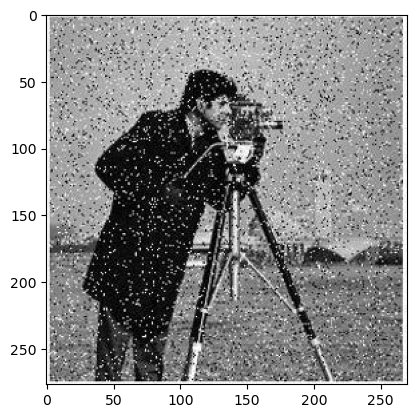

In [176]:
# Your code here
sample_image = io.imread("man.jpeg")
filter_kernel = f1
print(sample_image.shape)

R_1 = sample_image[:, :, 0] 
G_1 = sample_image[:, :, 1]
B_1 = sample_image[:, :, 2]

#formula for converting colour(RGB) to Gray Image scale Image
Y_sample = (0.299 * np.array(R_1)) + (0.587 * np.array(G_1)) + (0.114 * np.array(B_1)) 

plt.imshow(Y_sample , cmap = "gray")
print(Y_sample.shape)
print(Y_sample)

## Function "LaConvolution"

This function performs a standard convolution on an image the same way as signal.convolve2d with mode set to 'same'. This outputs the resulting image with the same size as the input image.

In [177]:
def convolve_region(args):
    img_cut, kernel, nbits, approx_until = args
    x, y = img_cut.shape
    k, l = kernel.shape
    # pad_image = np.pad(img_cut, ((k // 2, k // 2),(l // 2, l // 2)), mode = "constant")
    result = np.zeros_like(img_cut)
    total_energy = 0
    # print(pad_image.shape)

    for i in range(x):
        for j in range(y):
            # print("Coor:", i,j)
            img_cut_reg = img_cut[i:i+k, j:j+l]
            # print("Cut image region:", img_cut_reg)
            reg_multiplicated, reg_mult_enrg = laMultiplicationVect(img_cut_reg, kernel, nbits, approx_until)
            # print("Multiplicated region:", reg_multiplicated)
            result[i,j], energy = sumReduction(reg_multiplicated, nbits, approx_until)
            total_energy += reg_mult_enrg + energy

    return result, total_energy

def laConvolution(image, kernel, nbits = 12, approx_until = 0):
    x,y = image.shape
    k,l = kernel.shape
    flipped_kernel = np.flipud(np.fliplr(kernel))
    num_processes = 2 
    total_energy = 0
    print(image.shape)

    pad_image = np.pad(image, ((k // 2, k // 2),(l // 2, l // 2)), mode = "constant")

    # Divide the image into chunks for parallel processing. The image is divided
    # only in the x-axis
    chunk_size_x = (x + num_processes - 1) // num_processes
    print("Chunk_size", chunk_size_x)
    chunks = [(pad_image[i:i+chunk_size_x+k-1, :], flipped_kernel, nbits, approx_until) for i in range(0, x, chunk_size_x)]
    print(chunks)

    # Parallel processing
    with Pool(processes=num_processes) as pool:
        results = pool.map(convolve_region, chunks)

    # Combine results
    # print(results)
    result, total_energy = zip(*results)
    print(result)
    # print(result[0:1])
    # print([arr[1:] for arr in result[1:]])
    result = np.concatenate(result, axis=0)
    # result = np.concatenate(np.concatenate([result[0:1], [arr[1:] for arr in result[1:]]], axis=0), axis=0)
    # print(result)
    total_energy = sum(total_energy)

    return result[:x, :], total_energy


def laConvolutionSeq(image, kernel, nbits = 12, approx_until = 0):
    x, y           = image.shape
    k, l           = kernel.shape
    pad_image      = np.pad(image, ((k // 2, k // 2),(l // 2, l // 2)), mode = "constant")
    result         = np.zeros_like(image)
    flipped_kernel = np.flipud(np.fliplr(kernel))
    total_energy   = 0

    for i in range(x):
        for j in range(y):
            region = pad_image[i:i + k, j:j + l]
            reg_multiplicated, reg_mult_enrg = laMultiplicationVect(region, flipped_kernel, nbits = nbits, approx_until=approx_until)
            total_energy += reg_mult_enrg
            result[i, j], energy = sumReduction(reg_multiplicated, nbits = nbits, approx_until=approx_until)
            total_energy += energy

    return result, energy

kern2 = [
    [0,1],
    [1,1]
]

kern3 = [
    [-1,2,1],
    [0,1,0],
    [1,2,-1]
]

kern4 = [
    [-1, 0, 1, 2],
    [ 0, 1, 2, 3],
    [ 1, 2, 3, 2],
    [ 2, 3, 2,-1]
]

random_matrix = [
    [12, 79, 27,  2, 45,  4, 41, 62],
    [ 0, 93,  4, 39, 24, 13, 76, 73],
    [35, 50, 36, 81,  3, 15, 50, 95],
    [80, 78, 61, 95,  5, 79, 12, 56],
    [95, 74, 65, 16, 89, 73, 13, 10],
    [51, 35, 34,  6, 25, 40,  3, 90],
    [84, 92, 32, 48, 17, 93,  5, 14],
    [52, 54, 32, 68, 79, 91, 68, 71]
]

# Tests:
exact_convol = signal.convolve2d(random_matrix, kern2, mode = "same")
appr_convol,enrg = laConvolutionSeq(np.array(random_matrix),np.array(kern2)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("\033[91m", end='')
    print("Convolution with kern2 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("\033[92m", end='')
    print("SUCCESS: Convolution with kern2!")

print("\033[0m", end='')

exact_convol = signal.convolve2d(random_matrix, kern3, mode = "same")
appr_convol,enrg = laConvolutionSeq(np.array(random_matrix),np.array(kern3)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("\033[91m", end='')
    print("Convolution with kern3 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("\033[92m", end='')
    print("SUCCESS: Convolution with kern3!")

print("\033[0m", end='')

exact_convol = signal.convolve2d(random_matrix, kern4, mode = "same")
appr_convol,enrg = laConvolutionSeq(np.array(random_matrix),np.array(kern4)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("\033[91m", end='')
    print("Convolution with kern4 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("\033[92m", end='')
    print("SUCCESS: Convolution with kern4!")

print("\033[0m", end='')

SUCCESS: Convolution with kern2!
SUCCESS: Convolution with kern3!
SUCCESS: Convolution with kern4!


## Using filters

Some examples of using specified filters on our imported image.

477216


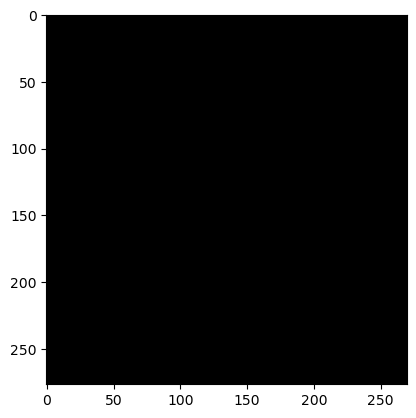

In [178]:
f1_img, enrg = laConvolutionSeq(Y_sample.astype(int),f1.astype(int))
print(enrg)
plt.imshow(f1_img, cmap = "gray")

317581


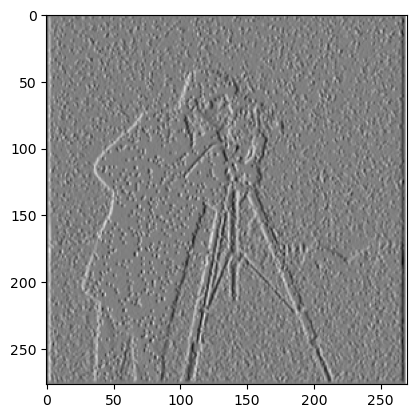

In [179]:
horiz_edges, enrg = laConvolutionSeq(Y_sample.astype(int),sobel_horizontal.astype(int))
print(enrg)
plt.imshow(horiz_edges, cmap = "gray")

358019


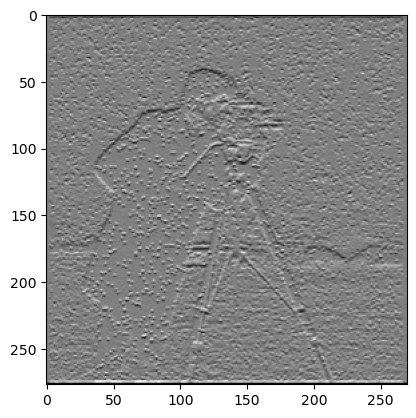

In [180]:
vert_edges, enrg = laConvolutionSeq(Y_sample.astype(int),sobel_vertical.astype(int))
print(enrg)
plt.imshow(vert_edges, cmap = "gray")

## Sobel edge detection

This uses two filters specified previously.

In [181]:

def adjust_bit_length(a):

    new_bit_length = math.ceil()

    return new_bit_length

# Function to perform convolution with the Sobel kernels
def sobelEdgeDetection(image, nbits = 12, approx_until = 0):

    total_energy = 0

    # filt_img= signal.convolve2d(image, f1, mode = "same")


    # Apply convolution with the horizontal and vertical Sobel kernels
    h_edges, h_enrg = laConvolutionSeq(image, sobel_horizontal, nbits=nbits, approx_until=approx_until)
    print("Horizontal convolution finished!")
    total_energy += h_enrg
    v_edges, v_enrg = laConvolutionSeq(image, sobel_vertical, nbits=nbits, approx_until=approx_until)
    print("Vertical convolution finished!")
    total_energy += v_enrg

    print(h_edges)
    print(v_edges)

    h_edg_sq, h_edg_sq_eng= laSquareVect(h_edges, nbits=nbits, approx_until=approx_until, use_parallel=True)
    print("Horizontal edge square finished!")
    total_energy += h_edg_sq_eng 
    v_edg_sq, v_edg_sq_eng= laSquareVect(v_edges, nbits=nbits, approx_until=approx_until, use_parallel=True)
    print("Vertical edge square finished!")
    total_energy += v_edg_sq_eng 

    print(h_edg_sq)
    print(v_edg_sq)

    # Calculate the magnitude of gradients
    magnitude_squared, mag_sq_eng = laAddVect(h_edg_sq, v_edg_sq, nbits=nbits, approx_until=approx_until, use_parallel=True) 
    print("Magnitude addition finished!")
    total_energy += mag_sq_eng 

    # magnitude_approx = apprSqRoot(magnitude_squared)
    magnitude_approxm, mag_appr_eng = laSqRootVect(magnitude_squared, nbits=nbits, approx_until=approx_until, use_parallel=True)
    total_energy += mag_appr_eng 

    # Normalize the magnitude to the range [0, 255]
    magnitude_normalized = ((magnitude_approx - np.min(magnitude_approx)) / (np.max(magnitude_approx) - np.min(magnitude_approx))) * 255

    # Convert the magnitude to uint8 data type
    # magnitude_uint8 = magnitude_normalized.astype(np.uint8)
    magnitude_uint8 = magnitude_normalized

    return magnitude_uint8,total_energy

det_edges, tot_energ = sobelEdgeDetection(Y_sample.astype(int))
print(tot_energ)
plt.imshow(det_edges, cmap = "gray")

Horizontal convolution finished!
Vertical convolution finished!
[[ -751   -12    11 ...    -4     2   735]
 [-1013     1   115 ...   -51    -8  1005]
 [-1015    67   295 ...  -193    -4  1012]
 ...
 [-1018   125   447 ...  -348    -3   994]
 [-1018    45   170 ...  -184     2  1007]
 [ -761    -2    13 ...   -12    -1   739]]
[[  749  1012  1005 ...  1020  1018   761]
 [    1   -13  -123 ...   -37    22    19]
 [    1   -49  -185 ...  -111   -32   -40]
 ...
 [   -8    25   193 ...   106    71    40]
 [    8    55   244 ...   108   -26   -13]
 [ -745 -1002  -987 ...  -982 -1017  -759]]
Horizontal edge square finished!
Vertical edge square finished!
[[-1247   144   121 ...    16     4  -447]
 [-1927     1   937 ... -1495    64 -1687]
 [-1967   393  1009 ...   385    16   144]
 ...
 [   36  -759  -895 ... -1776     9   900]
 [   36  2025   228 ...  1088     4 -1759]
 [ 1585     4   169 ...   144     1  1353]]
[[ -151   144 -1687 ...    16    36  1585]
 [    1   169 -1255 ...  1369   484  

KeyboardInterrupt: 

### Concluding analysis

This measures MSE, SSIM and PSNR when image processed by the LaConvolution function and by signal.convolve2d. The iteration over multiple approximation levels takes place as even more and more bits are approximated thus also the LaConvolution function's result gets more erroneous.

In [ ]:
exact_convolution_result = signal.convolve2d(Y_sample, sobel_horizontal, mode = "same")

# Your code here
for i in range(8):
    print("Number of approximated bits on addition: ", i)
    approx_convolution_result,_ = laConvolution(Y_sample, sobel_horizontal, i)

    data_range = exact_convolution_result.max() - exact_convolution_result.min()
   
    # Compare results and calculate error/similarity
    error = mse(exact_convolution_result, approx_convolution_result)
    print("    MSE = {}".format(error))
    similarity = ssim(exact_convolution_result, approx_convolution_result, data_range=data_range)
    print("    SSIM = {}".format(similarity))
    peak_snr = psnr(exact_convolution_result, approx_convolution_result, data_range=data_range)
    print("    PSNR = {}".format(peak_snr))

Number of approximated bits on addition:  0
    MSE = 1.0499532022997324
    SSIM = 0.9999544357541231
    PSNR = 65.98090392387495
Number of approximated bits on addition:  1
    MSE = 4.0713196951463715
    SSIM = 0.9973434978245925
    PSNR = 60.09525128717392
Number of approximated bits on addition:  2
    MSE = 47.27153362749028
    SSIM = 0.9569593537801396
    PSNR = 49.4466064253086
Number of approximated bits on addition:  3
    MSE = 332.6067923519187
    SSIM = 0.7419678317647987
    PSNR = 40.973292209038455
Number of approximated bits on addition:  4
    MSE = 1764.1348576012836
    SSIM = 0.3275058411140734
    PSNR = 33.727285535608495
Number of approximated bits on addition:  5
    MSE = 8128.762855996791
    SSIM = 0.07220725285143606
    PSNR = 27.092358809794316
Number of approximated bits on addition:  6
    MSE = 34650.7060034764
    SSIM = -0.015071695415806904
    PSNR = 20.795482471221426
Number of approximated bits on addition:  7
    MSE = 143259.63703703703
 